Basic draftsim analysis (by Arseny Khakhalin and Bobby Mills)

In [2]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

import sklearn.manifold as skm

In [3]:
from Arseny.draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [4]:
# Alternatives: XLN, DOM, M19, GRN, RNA, WAR
setName = 'WAR'

In [5]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [6]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

Change the addresses below if you store data ini a different folder locally:

In [7]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv',
    'WAR': '../2019-04-29 WAR prerelease leadup.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
3910313,WAR,"Liliana,_Dreadhorde_General,Liliana's_Triumph,...","Storrev,_Devkarin_Lich,Band_Together,Davriel,_...","God-Eternal_Bontu,Gleaming_Overseer,Vizier_of_...","Vivien,_Champion_of_the_Wilds,Nahiri,_Storm_of...","Awakening_of_Vitu-Ghazi,Challenger_Troll,Wards...","Sarkhan_the_Masterless,Spark_Harvest,Turret_Og...","Domri's_Ambush,Band_Together,Kiora,_Behemoth_B...","Chandra's_Triumph,Mobilized_District,Trusted_P..."
3910314,WAR,"Sarkhan_the_Masterless,Domri,_Anarch_of_Bolas,...","Dreadhorde_Invasion,Vizier_of_the_Scorpion,Dea...","Dovin,_Hand_of_Control,Law-Rune_Enforcer,Marty...","Roalesk,_Apex_Hybrid,Silent_Submersible,Samut,...","Kaya,_Bane_of_the_Dead,Spark_Harvest,Sorin's_T...","Ajani,_the_Greathearted,Jaya's_Greeting,Tibalt...","Vivien's_Arkbow,Cyclops_Electromancer,Spark_Do...","Domri's_Ambush,Jaya's_Greeting,Bolt_Bend,Turre..."
3910315,WAR,"Jaya,_Venerated_Firemage,Law-Rune_Enforcer,Pou...","Spark_Harvest,Casualties_of_War,Davriel,_Rogue...","Vizier_of_the_Scorpion,Angrath,_Captain_of_Cha...","Eternal_Skylord,Turret_Ogre,Sorin's_Thirst,Sky...","Enter_the_God-Eternals,Herald_of_the_Dreadhord...","God-Eternal_Oketra,The_Wanderer,Sorin,_Vengefu...","Jaya's_Greeting,Angrath,_Captain_of_Chaos,Emer...","Time_Wipe,Mowu,_Loyal_Companion,Ajani's_Pridem..."
3910316,WAR,"Teferi,_Time_Raveler,Tamiyo's_Epiphany,Guild_G...","Kaya,_Bane_of_the_Dead,Jaya's_Greeting,Law-Run...","Vraska,_Swarm's_Eminence,Bleeding_Edge,Eternal...","Eternal_Skylord,Vraska's_Finisher,Callous_Dism...","Samut,_Tyrant_Smasher,Arlinn,_Voice_of_the_Pac...","Enter_the_God-Eternals,Totally_Lost,Ugin's_Con...","Vivien's_Arkbow,Huatli,_the_Sun's_Heart,Courag...","Spark_Harvest,Jaya's_Greeting,Raging_Kronch,Ch..."
3910317,WAR,"Nissa,_Who_Shakes_the_World,Thundering_Ceratok...","Eternal_Skylord,Chandra's_Triumph,Mobilized_Di...","Nicol_Bolas,_Dragon-God,Kiora,_Behemoth_Beckon...","Ob_Nixilis's_Cruelty,Sorin's_Thirst,Soul_Divin...","God-Eternal_Kefnet,Augur_of_Bolas,Ral's_Outbur...","Domri,_Anarch_of_Bolas,Kasmina,_Enigmatic_Ment...","Bleeding_Edge,Gleaming_Overseer,Vraska's_Finis...","Ob_Nixilis's_Cruelty,Ob_Nixilis's_Cruelty,Tiba..."


In [8]:
# If you want to see a full record for any single card
# next(iter(thisSet.values()))

In [8]:
# Prepare for the main loop: 
# Initialize all vars to collect data
# We use basic arrays rather than numpy as they are ~10% faster

cardpicks = {cardName : [] for cardName in cardlist} # Pick order
nCards = len(cardlist)
pairs = [[0 for i in range(nCards)] for j in range(nCards)]  # Cards that were drafted together
freq = [0]*nCards
guilds = [[0 for i in range(5)] for j in range(5)]

Main loop (may take up to 10 minutes to run)

In [9]:
draftCount = 0
player = 'human' # normally should be: "human", but can also be "bot1" or any other bot
ticTime = time.time()
for pile in draftData[player]:#[0:500]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    draftCount = draftCount+1                 # For debugging
    colorCount = [0,0,0,0,0,0,0]
    for i in range(len(pile)):
        try:
            colorCount[getCardColor(thisSet[pile[i]])] += 1    # Count card colors within this pile only
            freq[cardlist.index(pile[i])] += 1                 # Total times this card was drafted
            
            for j in range(i):
                indi = cardlist.index(pile[i])
                indj = cardlist.index(pile[j])
                if indi>indj:
                    pairs[indi][indj] += 1                      # For now, only fill the left half of the matrix
                else:
                    pairs[indj][indi] += 1
            
            if i<14:
                cardpicks[pile[i]].append(i+1) # For ratings, we only look at the 1st booster as God knows what happens after
        
        except KeyError as e:
            print(pile)
            print(draftCount)
            raise
            
    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)
    if color1>1 and color2>1:            # Let's pretend that artifact-only and gold-only decks don't exist
        guilds[color1-2][color2-2] += 1

print("Time elapsed: ", time.time() - ticTime)
print("Total drafts analyzed: ", draftCount)

Time elapsed:  260.3128893375397
Total drafts analyzed:  61878


In [10]:
pairs = np.array(pairs)
freq = np.array(freq)
guilds = np.array(guilds)
# plt.imshow(pairs, cmap="Greys")

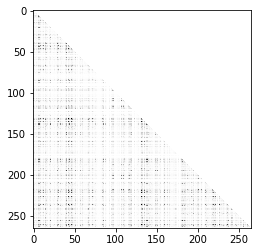

In [11]:
plt.imshow(pairs, cmap="Greys");

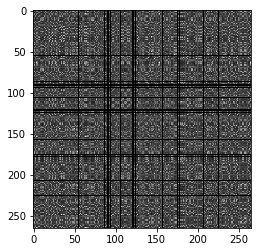

In [12]:
nDrafts = draftCount
prob = pairs*1.0 # Make a copy, and also make symmetric

for i in range(nCards):
    for j in range(i+1):
        if freq[i]>0 and freq[j]>0:
            prob[i,j] = prob[i,j]/float(freq[i])/float(freq[j])*nDrafts
            prob[j,i] = prob[i,j]
        
dist = (1-0.99*prob/prob.max())
plt.imshow(dist, cmap="Greys");

In [13]:
# Debugging: a list of cards that weren't drafted, but are in the db
for i in range(nCards):
    if freq[i]==0:
        print(cardlist[i])
        del cardpicks[cardlist[i]] # Remove undrafted cards from the dictionary

desperate_lunge
forest
gideon's_battle_cry
gideon's_company
gideon_the_oathsworn
guildpact_informant
island
jace's_projection
jace's_ruse
jace_arcane_strategist
mountain
orzhov_guildgate
plains
simic_guildgate
swamp
tezzeret_master_of_the_bridge


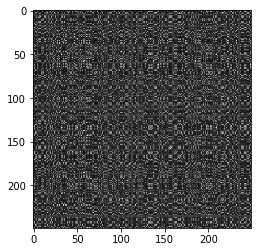

In [14]:
# Remove missing cards from other arrays
# (I make copies of both arrays for some reason, just in case)

dist2 = dist.copy()
dist2 = dist2[freq>0,:]
dist2 = dist2[:,freq>0] # For some reason if I try to subset both rows and columns together, it outputs something stupid
plt.imshow(dist2, cmap="Greys");

freq2 = freq[freq>0]

In [15]:
fit = skm.locally_linear_embedding(dist2, n_components=2, n_neighbors=len(freq2)-1)
fit = fit[0] # For some reason it returns a tuple

#embedding = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, eps=0.0001)
#fit = embedding.fit_transform(dist2)

In [16]:
df = pd.DataFrame({
        'avg'   : [np.mean(cardpicks[card]) for card in cardpicks],
        'var'   : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity': [thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks],
        'x' : fit[:,0],
        'y' : fit[:,1],
        'freq': freq2[:]
    }, list(cardpicks.keys()))

# Now some torturous attempt to use proper color names, while retaining their sequence
colorName = {0:"C", 1:"Multi", 2:"W", 3:"U", 4:"B", 5:"R", 6:"G"}
df['color'] = df.color.map(colorName)
from pandas.api.types import CategoricalDtype
ctype = CategoricalDtype(categories=["C","Multi","W","U","B","R","G"],ordered=True)
df['color'] = df['color'].astype(ctype)

df.head()

,avg,var,count,color,rarity,legendary,x,y,freq
ahn-crop_invader,9.386027,9.908926,6541,R,common,0,0.062386,-0.099133,19565
aid_the_fallen,6.901118,7.755378,3398,B,common,0,0.047972,0.102184,9872
ajani's_pridemate,4.036638,4.930770,1856,W,uncommon,0,-0.084390,0.009691,5253
ajani_the_greathearted,1.545697,1.161854,1499,Multi,rare,1,-0.105149,-0.013669,6407
angrath's_rampage,7.891935,15.813197,4414,Multi,uncommon,0,0.074900,-0.015892,10218


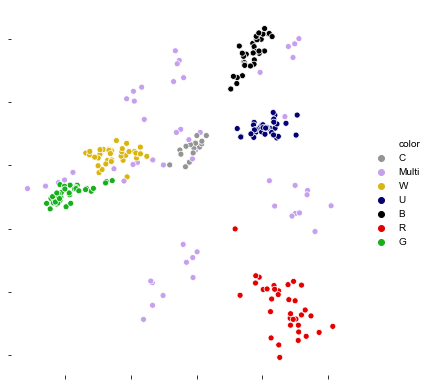

In [17]:
#%matplotlib inline

myPal = sns.xkcd_palette(["grey","lavender","gold","deep blue","black","red","green"])
s = sns.relplot(data=df,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

In [18]:
# Save the data.
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:

df.to_csv('Arseny/basic_data_'+setName+'.csv', index_label="name")
np.savetxt('Arseny/distances_'+setName+'.csv', dist2, delimiter=",")

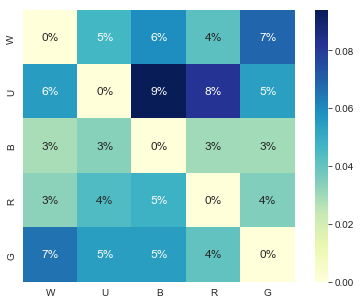

In [19]:
ax = sns.heatmap(guilds/np.sum(guilds), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

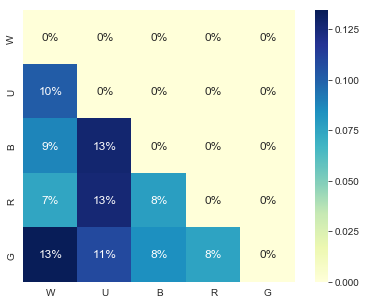

In [25]:
# Symmetric version for symmetric people
guilds_sim = guilds + guilds.transpose()
guilds_sim = np.triu(guilds_sim).transpose()

ax = sns.heatmap(guilds_sim/np.sum(guilds_sim), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

In [20]:
# Top picks:
df.sort_values(by=['avg'], ascending=True).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
liliana_dreadhorde_general,1.000000,0.000000,851,B,mythic,1,0.027931,0.070173,2357
finale_of_eternity,1.000000,0.000000,477,B,mythic,0,0.040904,0.078361,1350
god-eternal_bontu,1.000000,0.000000,528,B,mythic,1,0.030856,0.069233,1586
god-eternal_oketra,1.000000,0.000000,654,W,mythic,1,-0.051484,0.010844,1957
ilharg_the_raze-boar,1.000000,0.000000,572,R,mythic,1,0.033025,-0.102617,1653
roalesk_apex_hybrid,1.001647,0.001645,607,Multi,mythic,1,-0.062945,-0.002748,1917
finale_of_glory,1.002045,0.002041,489,W,mythic,0,-0.064648,0.004178,1517
chandra_fire_artisan,1.002107,0.002103,949,R,rare,1,0.062042,-0.102063,2769
nicol_bolas_dragon-god,1.002567,0.002561,779,Multi,mythic,1,0.067138,0.038415,3472
jace_wielder_of_mysteries,1.003297,0.003286,910,U,rare,1,0.049672,0.031861,2934


In [21]:
# Top controversial cards (without correction for 'intrinsic controversy')
df.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
niv-mizzet_reborn,9.245584,19.790971,1755,Multi,mythic,1,-0.003242,0.005032,5329
role_reversal,8.825334,18.330625,2542,Multi,rare,0,0.059338,-0.032175,6642
tamiyo_collector_of_tales,7.550562,18.056111,3115,Multi,rare,1,-0.033402,0.004206,8149
teferi_time_raveler,6.843373,17.971306,4565,Multi,rare,1,-0.005928,0.020180,11156
tenth_district_legionnaire,6.990732,17.766365,3237,Multi,uncommon,0,-0.002791,-0.088594,8202
rubblebelt_rioters,7.738573,16.628794,2341,Multi,uncommon,0,-0.033585,-0.110486,6809
mayhem_devil,7.360639,16.025956,2942,Multi,uncommon,0,0.083992,-0.023251,7795
pledge_of_unity,8.480060,15.979287,5993,Multi,uncommon,0,-0.100536,-0.011587,14012
angrath's_rampage,7.891935,15.813197,4414,Multi,uncommon,0,0.074900,-0.015892,10218
cruel_celebrant,7.520586,15.739665,3279,Multi,uncommon,0,-0.013261,0.082732,8132
